In [82]:
import pandas as pd
import numpy as np
import ipyvolume as ipv

In [83]:
%pwd

'c:\\Apps\\Hackathon'

In [113]:
from pandas import read_excel
my_sheet_name = 'Sheet1' 
df = read_excel('11_2.xlsx', sheet_name = my_sheet_name)
print(df.head()) # shows headers with top 5 rows

              UID       Well             Top Interpreter  Depth_MD  \
0  11000090507701     US-008  AS 11.2 (Sand)       PRJ__   2189.40   
1       SVA-51005  SVA-51005          AS11.2       UNKNO   2550.99   
2  99000010166301      US-62          AS11.2         SPD   2311.00   
3  99000010117801   US-24008          AS11.2        UNKN   2699.32   
4  11000090404301     US-032          AS11.2        UNKN   2215.03   

   Depth_tvdss        Easting      Northing  
0   -2129.0000  620549.130000  6.643251e+06  
1   -2471.0854  612153.560000  6.677389e+06  
2   -2113.2766  626877.718685  6.643734e+06  
3   -2127.0000  624102.896736  6.653115e+06  
4   -2121.6533  610893.850000  6.655695e+06  


In [ ]:
#df.loc[:,['UID','Well','Top','Interpreter','Depth_MD','Easting','Northing','Depth_tvdss']]

In [ ]:
#df.loc[df.Top.isin(['AS11.2','T AS11.2']), ['Easting','Northing','Depth_tvdss']]

In [114]:
xyz=df.loc[df.Top.isin(['AS11.2','T AS11.2']), ['Easting','Northing','Depth_tvdss']].values

In [115]:
#Exctract XYZ values for processing
x=xyz[:,0]
y=xyz[:,1]
z=xyz[:,2]

In [116]:
#Get extents of input data
xmin=x.min() ; ymin=y.min() ; xmax=x.max() ; ymax=y.max() ; zmin=z.min() ; zmax=z.max()

### Initial processing to mathematically remove obvious outliers

In [117]:
def outliers_iqr(z):
    """
    The interquartile range (IQR), also called the midspread or middle 50%, 
    or technically H-spread, is a measure of statistical dispersion, being equal to the difference 
    between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.
    In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles 
    can be clearly seen on a box plot on the data.
    It is a measure of the dispersion similar to standard deviation or variance, but is much more robust 
    against outliers.
    """
    quartile_1, quartile_3 = np.percentile(z, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((z > upper_bound) | (z < lower_bound))
iqr_test = outliers_iqr(z)[0].tolist()
x_smooth = np.delete(x,iqr_test)
y_smooth = np.delete(y,iqr_test)
z_smooth = np.delete(z,iqr_test)
ipv.figure()
s = ipv.scatter(x_smooth, y_smooth, z_smooth, marker='sphere', size=3)
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(-4000,-1500)
ipv.animation_control(s)# shows controls for animation controls
ipv.selector_default()
ipv.show()

Output()

### Iterative interactive editing

In [89]:
s_sel=s.selected
k=s_sel[0].tolist()

In [90]:
#Pick up points edited in first 'outlier edit' funtion
x= x_smooth
y = y_smooth
z = z_smooth

In [91]:
xdel=np.delete(x,k)
ydel=np.delete(y,k)
zdel=np.delete(z,k)

In [92]:
ipv.figure()
sdel = ipv.scatter(xdel, ydel, zdel, marker='sphere', size=3)
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(-4000,-1500)
ipv.animation_control(s)# shows controls for animation controls
ipv.selector_default()
ipv.show()

Output()

### Second edit iteration

In [93]:
k2=sdel.selected[0].tolist()

In [94]:
xdel2=np.delete(xdel,k2)
ydel2=np.delete(ydel,k2)
zdel2=np.delete(zdel,k2)

In [95]:
ipv.figure()
sdel2 = ipv.scatter(xdel2, ydel2, zdel2, marker='sphere', size=3)
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(-4000,-1500)
ipv.animation_control(s)# shows controls for animation controls
ipv.selector_default()
ipv.show()

Output()

### Grid up  edited data

In [96]:
#Reassign edited data to X,Y,Z variable
x, y, z = xdel2, ydel2, zdel2

### Grid Tops via minimum curvature

In [97]:
#Create a grid outline from tops data extent. Start printing extent
print("Xmin = {} , XMax = {}\nYmin = {}, Ymax= {}\nZmin = {}, Zmax = {}".format(xmin, xmax, ymin, ymax, zmin, zmax))

Xmin = 595608.87 , XMax = 628209.11
Ymin = 6639937.51, Ymax= 6699306.54
Zmin = -3000.22, Zmax = -2108.3


In [98]:
#Create sensible grid outline of integers. Now hardcoded...
extent = [596000, 628500, 6640000, 6700000] #Sensible numbers from observed Xmin and Ymin
grid_int = 2000 #Hard coded grid spacing
#Create arrays of the x and y axis
x_points = int((extent[1] - extent[0]) / grid_int)
y_points = int((extent[3] - extent[2]) / grid_int)

# KDTree 

In [99]:
from scipy import spatial

In [118]:
#Create sensible grid outline of integers. Now hardcoded...
extent = [596000, 628500, 6640000, 6700000] #Sensible numbers from observed Xmin and Ymin
grid_int = 2000 #Hard coded grid spacing
#Create arrays of the x and y axis
x_points = int((extent[1] - extent[0]) / grid_int)
y_points = int((extent[3] - extent[2]) / grid_int)

In [119]:
#Create the grid. interval expressed by complex numbers
grid_x, grid_y = np.mgrid[extent[0]:extent[1]:complex(x_points), extent[2]:extent[3]:complex(y_points)]

In [120]:
#Create numpy arrays of point co-ordinates and then values from input data
points = np.array(list(zip(x, y)))
values = z

In [102]:
tree = spatial.KDTree(points.tolist())

In [103]:
keep=list(set(tree.query(list(zip(grid_x.ravel(), grid_y.ravel())))[1]))
xk,yk,zk = x[keep],y[keep],z[keep]

In [109]:
xk.shape

(43,)

In [110]:
keepdist=list(set(tree.query(list(zip(grid_x.ravel(), grid_y.ravel())))[0]))

In [111]:
keepdist

[4098.006038886149,
 2068.0190764368194,
 4119.530255952911,
 8216.892159097255,
 2074.58336674184,
 2077.4563069200785,
 2078.471670872095,
 2079.1636999213524,
 4128.207871689511,
 4128.605968027206,
 10277.186540428142,
 4135.101801652931,
 2090.030175300818,
 12330.905395186577,
 2095.7179097002813,
 10303.14022306125,
 2121.100576388987,
 4176.345457897669,
 6225.538030939278,
 2132.6978076077626,
 4187.963555147434,
 2142.742743273055,
 4202.915549067547,
 2155.2941723597078,
 4204.8244889870575,
 6253.701642680345,
 4203.075215940932,
 4213.18868313732,
 4213.86952132567,
 6264.670155835425,
 2173.8322730384225,
 2179.638992413444,
 2179.8131646852535,
 4231.245572208825,
 2184.6976656170295,
 4238.781563224192,
 2191.0030692601017,
 2192.253301890163,
 2197.7823732448837,
 2198.590375490351,
 2211.7960218814987,
 2224.3171098657713,
 2233.410479004438,
 4282.000398468745,
 10434.834561980198,
 4294.352580745767,
 2248.787601281377,
 6352.513682365188,
 4304.02791665784,
 4313.7

In [121]:
#Perform interpolation of data in to the specified grid using scipy
from scipy.interpolate import griddata
gridded = griddata(points, values, (grid_x, grid_y), method='cubic')

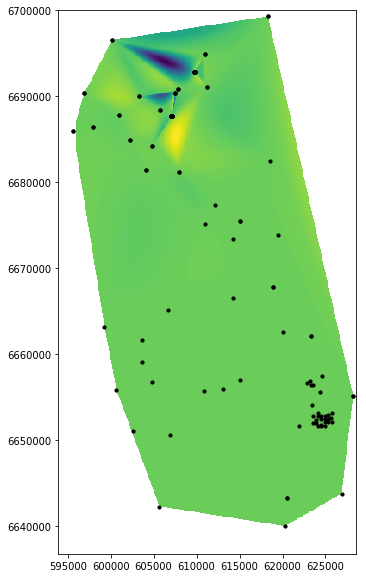

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
plt.imshow(gridded.T, origin='lower', extent=extent)
plt.scatter(xd, yd, s=10, c='k')
#plt.colorbar(gridded.T)

### 2d Fourier Transform

In [ ]:
#Subset data to rectangle. In final version, will have already selected rectangle in ipyvolume phase

In [34]:
gridded.shape

(325, 600)

In [ ]:
ft = np.fft.fft2(gridded)

# Read Depth map

In [7]:
%pwd
%cd ..\..

c:\Apps\Hackathon


In [4]:

# library 


from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 

In [60]:

# Get the data (csv file )
 

data = pd.read_csv('surface66.txt', sep='      ', skiprows=[1], header = None, engine='python',names=['Easting','Northing','Depth']) 



In [64]:
data.shape

(2880906, 3)

In [62]:
data = data.iloc[1:]

In [73]:
data['Depth'].shape

(2880906,)